#XAI: Spójność wyników

##Importy

In [ ]:
!pip -q install shap lime eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

## Wczytanie danych

W Projekcie został użyty dataset Iris dostępny w scikit learn

In [ ]:
iris = load_iris(as_frame=True)
X = iris.data.copy()
y = iris.target.copy()
feature_names = list(X.columns)
class_names = list(iris.target_names)

df = X.copy()
df["target"] = y
df["class_name"] = df["target"].map(lambda t: class_names[t])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,class_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [ ]:
print("Kształt X:", X.shape)
print("Rozkład klas:")
display(df["class_name"].value_counts())

Kształt X: (150, 4)
Rozkład klas:


,count
class_name,
setosa,50
versicolor,50
virginica,50


## Prosty wykres rozkładów cech

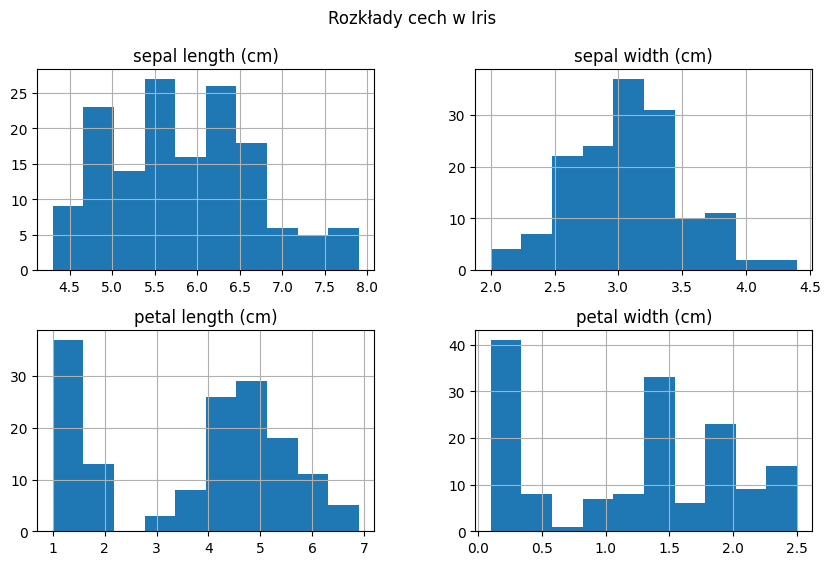

In [ ]:
X.hist(figsize=(10,6))
plt.suptitle("Rozkłady cech w Iris")
plt.show()

##Podział na zbiór treningowy i testowy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (120, 4)  Test: (30, 4)


##Budowa modeli

W projekcie użyto dwóch modeli aby lepiej porównać wyniki oraz zobaczyć czy zajdą jakieś zmiany po standaryzacji danych: Regresje Logistyczną i Random Forrest

In [ ]:
lr_clf = Pipeline(steps=[
    ("scaler", StandardScaler()), #dodana standaryzacja
    ("model", LogisticRegression(max_iter=200, multi_class="auto", random_state=42))])

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42)

lr_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)

print("Accuracy LR:", accuracy_score(y_test, lr_pred))
print("Accuracy RF:", accuracy_score(y_test, rf_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy LR: 0.9333333333333333
Accuracy RF: 0.9


##Raport klasyfikacji dla bazowych modeli

In [ ]:
print(classification_report(y_test, lr_pred, target_names=class_names))

print(classification_report(y_test, rf_pred, target_names=class_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



Oba modele bardzo dobrze klasyfikują klasę setosa, natomiast największe trudności pojawiają się przy rozróżnianiu versicolor i virginica. Pierwszy model osiąga wyższą skuteczność ogólną (accuracy 0.93) i bardziej stabilne wyniki niż drugi, który ma nieco niższe F1-score dla tych dwóch klas.

#Wyjaśnienia globalne

##Wagi

- LR: współczynniki (po standaryzacji sensownie porównywalne)
- RF: wbudowane feature_importances_ (oparte o spadek nieczystości)

###Regrecja Logistyczna

In [ ]:
# Pipeline: scaler + model. Wagi są w kroku "model".
lr_model = lr_clf.named_steps["model"]
coef = lr_model.coef_

coef_df = pd.DataFrame(coef, columns=feature_names, index=class_names)
coef_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
setosa,-1.088945,1.024208,-1.799056,-1.686228
versicolor,0.536337,-0.360487,-0.204074,-0.807957
virginica,0.552608,-0.663721,2.003130,2.494185


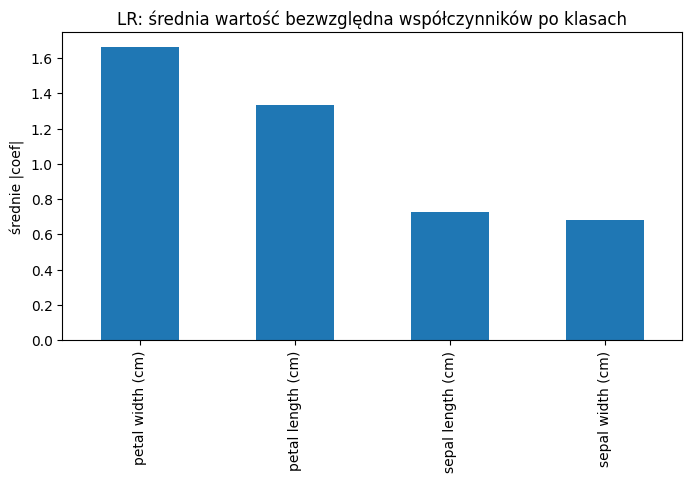

,0
petal width (cm),1.662790
petal length (cm),1.335420
sepal length (cm),0.725963
sepal width (cm),0.682805


In [ ]:
lr_global_strength = coef_df.abs().mean(axis=0).sort_values(ascending=False)
lr_global_strength.plot(kind="bar", figsize=(8,4))
plt.title("LR: średnia wartość bezwzględna współczynników po klasach")
plt.ylabel("średnie |coef|")
plt.show()

lr_global_strength

W regresji logistycznej średnia wartość bezwzględna współczynników po klasach pozwala ocenić globalne znaczenie cech, ponieważ wcześniejsza standaryzacja sprawia, że współczynniki są bezpośrednio porównywalne. Największy wpływ na decyzje modelu mają cechy petal width i petal length, natomiast cechy kielicha odgrywają mniejszą rolę. Oznacza to, że model w największym stopniu opiera się na informacjach związanych z płatkami, co jest zgodne z charakterystyką zbioru Iris.

###Random forrest

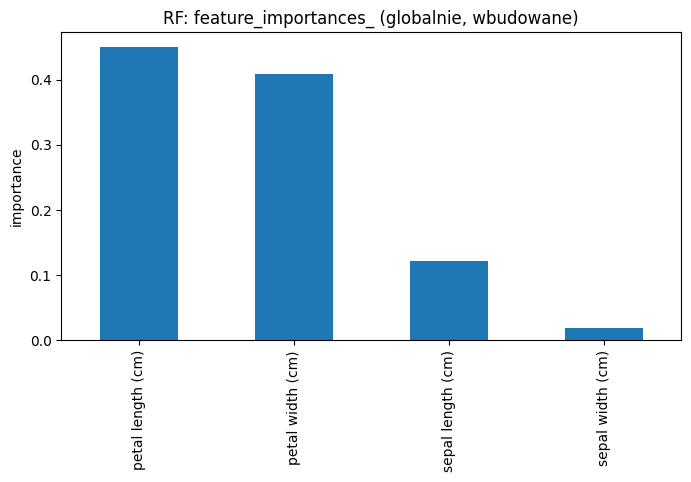

,0
petal length (cm),0.450316
petal width (cm),0.409548
sepal length (cm),0.121454
sepal width (cm),0.018682


In [ ]:
rf_imp = pd.Series(rf_clf.feature_importances_, index=feature_names).sort_values(ascending=False)
rf_imp.plot(kind="bar", figsize=(8,4))
plt.title("RF: feature_importances_ (globalnie, wbudowane)")
plt.ylabel("importance")
plt.show()

rf_imp

W przypadku modelu Random Forest wbudowane miary feature_importances_ pokazują, że największe znaczenie mają cechy petal length oraz petal width, które odpowiadają za większość redukcji nieczystości w drzewach decyzyjnych. Cechy kielicha, a szczególnie sepal width, mają znacznie mniejszy wpływ na decyzje modelu. Oznacza to, że klasyfikacja opiera się głównie na informacjach związanych z płatkami, co jest spójne zarówno z wynikami regresji logistycznej, jak i z charakterystyką zbioru Iris.

##Permutation importance

- test jednej cechy w X_test
- Obserwacja spadku jakości
Im większy spadek, tym cecha ważniejsza.

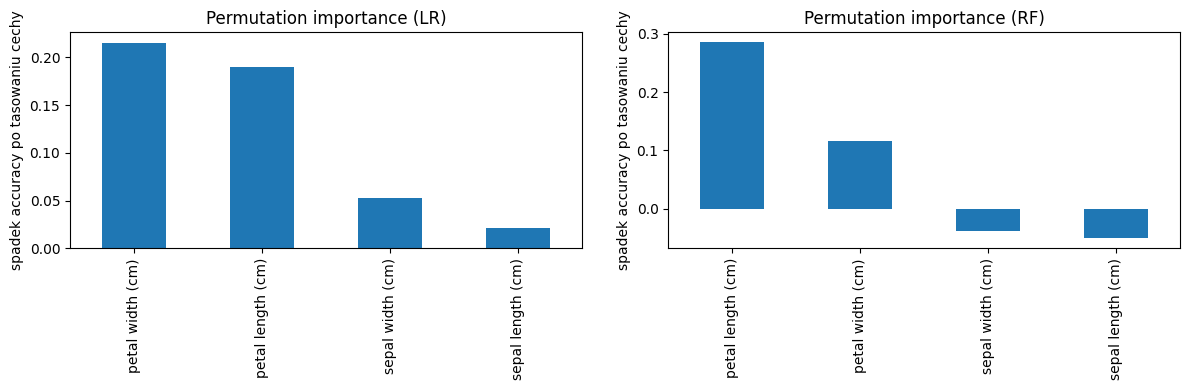

(petal width (cm)     0.215556
 petal length (cm)    0.190000
 sepal width (cm)     0.052222
 sepal length (cm)    0.021111
 dtype: float64,
 petal length (cm)    0.285556
 petal width (cm)     0.116667
 sepal width (cm)    -0.037778
 sepal length (cm)   -0.051111
 dtype: float64)

In [ ]:
def perm_imp(model, X_test, y_test, n_repeats=30):
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=n_repeats,
        random_state=42,
        scoring="accuracy"
    )
    return pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

perm_lr = perm_imp(lr_clf, X_test, y_test)
perm_rf = perm_imp(rf_clf, X_test, y_test)

fig, axes = plt.subplots(1,2, figsize=(12,4))
perm_lr.plot(kind="bar", ax=axes[0])
axes[0].set_title("Permutation importance (LR)")
axes[0].set_ylabel("spadek accuracy po tasowaniu cechy")

perm_rf.plot(kind="bar", ax=axes[1])
axes[1].set_title("Permutation importance (RF)")
axes[1].set_ylabel("spadek accuracy po tasowaniu cechy")
plt.tight_layout()
plt.show()

perm_lr, perm_rf

Permutation importance pokazuje, jak bardzo spada dokładność modelu po losowym przetasowaniu wartości danej cechy, co pozwala ocenić jej realny wpływ na jakość predykcji. Dla regresji logistycznej największy spadek dokładności powoduje tasowanie petal width i petal length, natomiast dla Random Forest kluczowa jest petal length, przy czym cechy kielicha mają niewielki lub zerowy wpływ.

##SHAP globalnie

Obliczony średni absolutny wkład dla każdej klasy

In [ ]:
import shap

X_train_np = X_train.values
X_test_np = X_test.values

# Dla LR: użyta predykcja probabilistyczna
# shap.Explainer spróbuje dobrać explainer automatycznie
explainer_lr = shap.Explainer(lr_clf.predict_proba, X_train_np, feature_names=feature_names)
shap_values_lr = explainer_lr(X_test_np)

# Dla RF:
explainer_rf = shap.Explainer(rf_clf.predict_proba, X_train_np, feature_names=feature_names)
shap_values_rf = explainer_rf(X_test_np)

print("SHAP LR values shape:", shap_values_lr.values.shape)
print("SHAP RF values shape:", shap_values_rf.values.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

SHAP LR values shape: (30, 4, 3)
SHAP RF values shape: (30, 4, 3)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


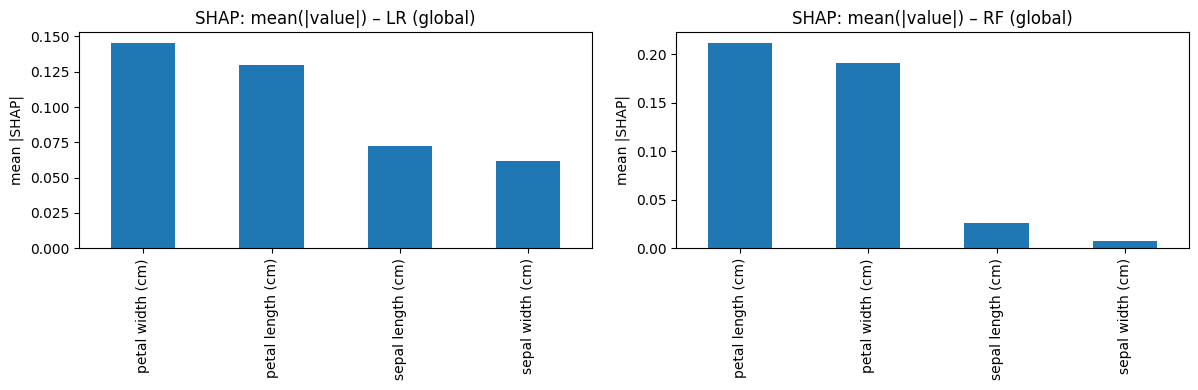

(petal width (cm)     0.145605
 petal length (cm)    0.129805
 sepal length (cm)    0.072596
 sepal width (cm)     0.061696
 dtype: float64,
 petal length (cm)    0.212093
 petal width (cm)     0.191144
 sepal length (cm)    0.026213
 sepal width (cm)     0.007330
 dtype: float64)

In [ ]:
def shap_global_importance(shap_values):
    vals = shap_values.values
    return pd.Series(np.mean(np.abs(vals), axis=(0,2)), index=feature_names).sort_values(ascending=False)

shap_imp_lr = shap_global_importance(shap_values_lr)
shap_imp_rf = shap_global_importance(shap_values_rf)

fig, axes = plt.subplots(1,2, figsize=(12,4))
shap_imp_lr.plot(kind="bar", ax=axes[0])
axes[0].set_title("SHAP: mean(|value|) – LR (global)")
axes[0].set_ylabel("mean |SHAP|")

shap_imp_rf.plot(kind="bar", ax=axes[1])
axes[1].set_title("SHAP: mean(|value|) – RF (global)")
axes[1].set_ylabel("mean |SHAP|")

plt.tight_layout()
plt.show()

shap_imp_lr, shap_imp_rf

Globalna analiza SHAP, oparta na średniej wartości bezwzględnej wkładów cech, pokazuje, które zmienne mają największy wpływ na predykcje modeli w całym zbiorze danych. Zarówno dla regresji logistycznej, jak i dla Random Forest, najwyższe wartości osiągają petal length i petal width, natomiast cechy kielicha mają wyraźnie mniejsze znaczenie. Oznacza to, że niezależnie od typu modelu SHAP wskazuje spójny wzorzec, w którym decyzje klasyfikacyjne są determinowane głównie przez informacje zawarte w płatkach irysa.

##Porównanie globalnych rankingów danych

In [ ]:
def top_k(series, k=3):
    return list(series.index[:k])

summary_global = pd.DataFrame({
    "LR_coef_top3": [', '.join(top_k(lr_global_strength, 4))],
    "LR_perm_top3": [', '.join(top_k(perm_lr, 4))],
    "LR_shap_top3": [', '.join(top_k(shap_imp_lr, 4))],
    "RF_builtin_top3": [', '.join(top_k(rf_imp, 4))],
    "RF_perm_top3": [', '.join(top_k(perm_rf, 4))],
    "RF_shap_top3": [', '.join(top_k(shap_imp_rf, 4))]
})

pd.set_option('display.max_colwidth', None)
display(summary_global.T)

,0
LR_coef_top3,"petal width (cm), petal length (cm), sepal length (cm), sepal width (cm)"
LR_perm_top3,"petal width (cm), petal length (cm), sepal width (cm), sepal length (cm)"
LR_shap_top3,"petal width (cm), petal length (cm), sepal length (cm), sepal width (cm)"
RF_builtin_top3,"petal length (cm), petal width (cm), sepal length (cm), sepal width (cm)"
RF_perm_top3,"petal length (cm), petal width (cm), sepal width (cm), sepal length (cm)"
RF_shap_top3,"petal length (cm), petal width (cm), sepal length (cm), sepal width (cm)"


## Wizualizacja spójności ważności cech: Mapa cieplna znormalizowanych wyników

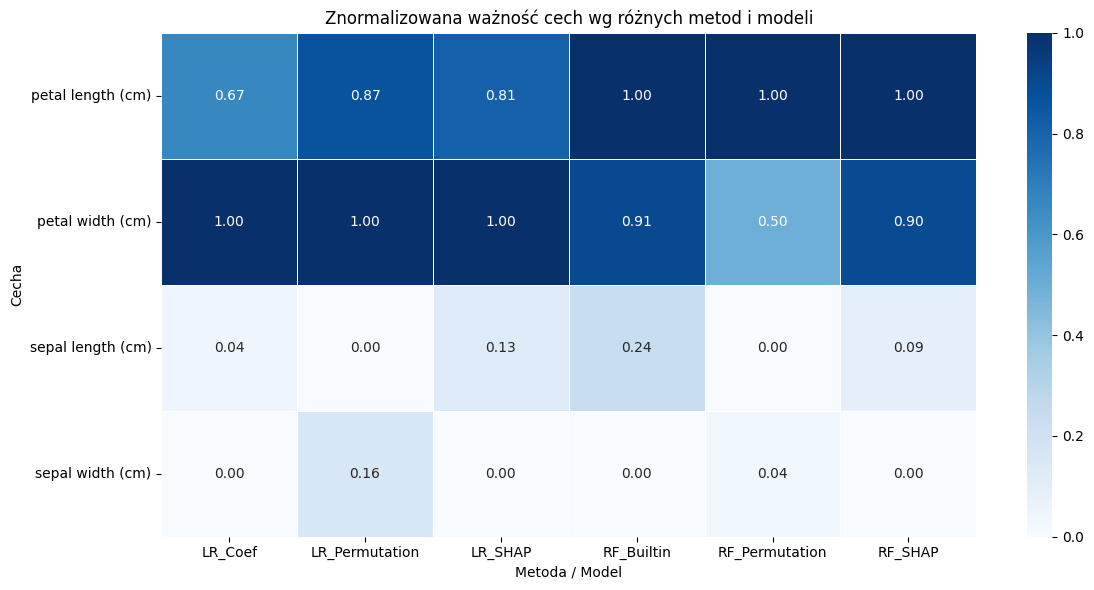

In [ ]:
import seaborn as sns

combined_importance_df = pd.DataFrame({
    "LR_Coef": lr_global_strength,
    "LR_Permutation": perm_lr,
    "LR_SHAP": shap_imp_lr,
    "RF_Builtin": rf_imp,
    "RF_Permutation": perm_rf,
    "RF_SHAP": shap_imp_rf,
}).fillna(0)

normalized_importance_df = combined_importance_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

plt.figure(figsize=(12, 6))
sns.heatmap(normalized_importance_df, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title("Znormalizowana ważność cech wg różnych metod i modeli")
plt.xlabel("Metoda / Model")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()

Znormalizowana mapa cieplna pozwala bezpośrednio porównać ważność cech pomiędzy różnymi metodami wyjaśniania i modelami, niezależnie od skali ich oryginalnych miar. We wszystkich przypadkach najwyższe wartości osiągają cechy petal length i petal width, co wynika z faktu, że to właśnie one najlepiej separują klasy versicolor i virginica w zbiorze Iris, natomiast cechy kielicha mają znacznie słabszą moc dyskryminacyjną. Regresja logistyczna przypisuje tym cechom wysokie współczynniki, ponieważ w sposób liniowy maksymalizują one separację klas, Random Forest wykorzystuje je najczęściej do podziałów w drzewach decyzyjnych, a metody wyjaśniania (SHAP i permutation importance) potwierdzają ich znaczenie, pokazując duży wpływ na predykcję oraz wyraźny spadek jakości po ich zaburzeniu. Jednocześnie różnice w intensywności kolorów między metodami wynikają z odmiennych definicji „ważności” — SHAP rozdziela wkład cech w predykcję, permutation importance mierzy wpływ na accuracy, a wbudowane miary RF opierają się na redukcji nieczystości — jednak wszystkie trzy podejścia prowadzą do spójnego wniosku co do kluczowej roli cech płatków.

#Wyjaśnienia lokalne

##Sprawdzenie błędnie przypisanych obserwacji

In [ ]:
idx_misclassified = None
y_test_list = y_test.tolist()
for i in range(len(X_test)):
    if i == 0:
        continue
    true_class = y_test_list[i]
    current_x_test = X_test.iloc[[i]]
    lr_pred = lr_clf.predict(current_x_test)[0]
    rf_pred = rf_clf.predict(current_x_test)[0]
    if idx_misclassified is None and (lr_pred != true_class or rf_pred != true_class):
        idx_misclassified = i
    if idx_misclassified is not None:
        break

print(f"Wybrany indeks dla błędnie sklasyfikowanej obserwacji (idx_misclassified): {idx_misclassified}")
if idx_misclassified is None:
    print("Nie znaleziono błędnie sklasyfikowanej obserwacji (poza indeksem 0).")

Wybrany indeks dla błędnie sklasyfikowanej obserwacji (idx_misclassified): 19


##Predykcje dla obswerwacji 0

In [ ]:
idx = 0  # Wybór obserwacji do wyjaśniania
x0 = X_test.iloc[idx]
x0_np = x0.values.reshape(1, -1)

true_class = class_names[y_test.iloc[idx]]
pred_lr = class_names[lr_clf.predict(x0_np)[0]]
pred_rf = class_names[rf_clf.predict(x0_np)[0]]

print("Obserwacja testowa idx =", idx)
display(x0.to_frame(name="value"))
print("Prawdziwa klasa:", true_class)
print("Predykcja LR:", pred_lr)
print("Predykcja RF:", pred_rf)

Obserwacja testowa idx = 0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,value
sepal length (cm),4.4
sepal width (cm),3.0
petal length (cm),1.3
petal width (cm),0.2


Prawdziwa klasa: setosa
Predykcja LR: setosa
Predykcja RF: setosa


##Pradykcje dla obserwacji 19

In [ ]:
idx2 = 19  # Wybór obserwacji do wyjaśniania
x02 = X_test.iloc[idx2]
x0_np2 = x02.values.reshape(1, -1)

true_class2 = class_names[y_test.iloc[idx2]]
pred_lr2 = class_names[lr_clf.predict(x0_np2)[0]]
pred_rf2 = class_names[rf_clf.predict(x0_np2)[0]]

print("Obserwacja testowa idx =", idx)
display(x02.to_frame(name="value"))
print("Prawdziwa klasa:", true_class2)
print("Predykcja LR:", pred_lr2)
print("Predykcja RF:", pred_rf2)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Obserwacja testowa idx = 0


,value
sepal length (cm),6.0
sepal width (cm),3.0
petal length (cm),4.8
petal width (cm),1.8


Prawdziwa klasa: virginica
Predykcja LR: virginica
Predykcja RF: versicolor


Do analizy wyjaśnień lokalnych wybrano pierwszą oraz dziewiętnastą obserwację ze zbioru testowego, jedna została poprawnie sklasyfikowana przez oba modele, a druga tylko przez jeden.

###SHAP lokalnie

###Dla obserwacji 0

In [ ]:
# SHAP dla pojedynczej obserwacji
sv_lr_one = explainer_lr(x0_np)
sv_rf_one = explainer_rf(x0_np)

pred_class_lr = int(lr_clf.predict(x0_np)[0])
pred_class_rf = int(rf_clf.predict(x0_np)[0])

lr_contrib = pd.Series(
    sv_lr_one.values[0, :, pred_class_lr],
    index=feature_names
).sort_values(key=lambda s: np.abs(s), ascending=False)

rf_contrib = pd.Series(
    sv_rf_one.values[0, :, pred_class_rf],
    index=feature_names
).sort_values(key=lambda s: np.abs(s), ascending=False)

display(pd.DataFrame({
    "SHAP_LR_for_pred_class": lr_contrib,
    "SHAP_RF_for_pred_class": rf_contrib
}))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,SHAP_LR_for_pred_class,SHAP_RF_for_pred_class
petal length (cm),0.248135,0.340250
petal width (cm),0.116216,0.293572
sepal length (cm),0.275249,0.041706
sepal width (cm),0.021616,0.005072


##Dla obserwacji 19

In [ ]:
sv_lr_one_idx2 = explainer_lr(x0_np2)
sv_rf_one_idx2 = explainer_rf(x0_np2)

pred_class_lr_idx2 = int(lr_clf.predict(x0_np2)[0])
pred_class_rf_idx2 = int(rf_clf.predict(x0_np2)[0])

lr_contrib_idx2 = pd.Series(
    sv_lr_one_idx2.values[0, :, pred_class_lr_idx2],
    index=feature_names
).sort_values(key=lambda s: np.abs(s), ascending=False)

rf_contrib_idx2 = pd.Series(
    sv_rf_one_idx2.values[0, :, pred_class_rf_idx2],
    index=feature_names
).sort_values(key=lambda s: np.abs(s), ascending=False)

display(pd.DataFrame({
    "SHAP_LR_for_pred_class_idx2": lr_contrib_idx2,
    "SHAP_RF_for_pred_class_idx2": rf_contrib_idx2
}))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,SHAP_LR_for_pred_class_idx2,SHAP_RF_for_pred_class_idx2
petal length (cm),0.071246,0.226883
petal width (cm),0.160192,-0.113367
sepal length (cm),0.003974,0.100011
sepal width (cm),-0.001856,-0.021961


Lokalne wyjaśnienie SHAP pokazuje, które cechy miały największy wpływ na predykcję konkretnej obserwacji dla klasy przewidzianej przez model. Zarówno w regresji logistycznej, jak i w Random Forest, kluczową rolę odgrywają cechy płatków, przy czym ich wkład jest wyraźnie większy niż cech kielicha. Różnice w wartościach SHAP pomiędzy modelami wynikają z odmiennej struktury modeli, jednak oba wskazują te same cechy jako decydujące dla tej konkretnej decyzji.

##Wizualizacja

###Dla obserwacji 0

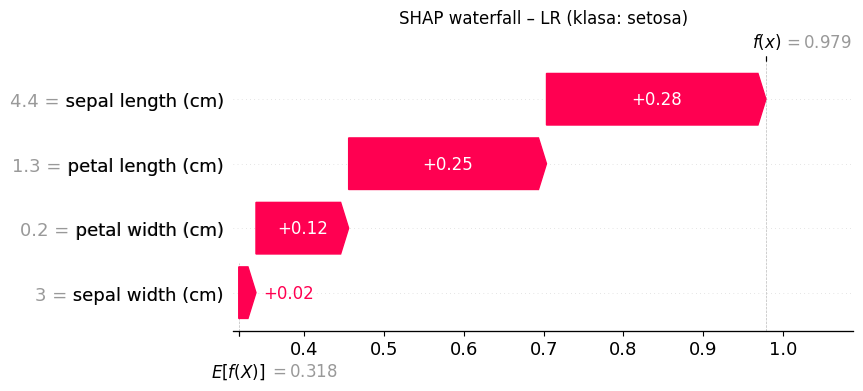

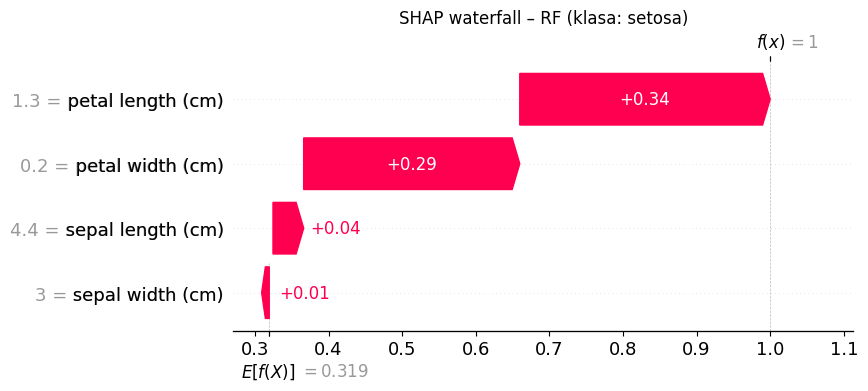

In [ ]:
def select_class_explanation(shap_values_one, class_idx):
    return shap.Explanation(
        values=shap_values_one.values[0, :, class_idx],
        base_values=shap_values_one.base_values[0, class_idx],
        data=shap_values_one.data[0],
        feature_names=feature_names
    )

exp_lr = select_class_explanation(sv_lr_one, pred_class_lr)
exp_rf = select_class_explanation(sv_rf_one, pred_class_rf)

plt.figure()
shap.plots.waterfall(exp_lr, show=False)
plt.title(f"SHAP waterfall – LR (klasa: {class_names[pred_class_lr]})")
plt.show()

plt.figure()
shap.plots.waterfall(exp_rf, show=False)
plt.title(f"SHAP waterfall – RF (klasa: {class_names[pred_class_rf]})")
plt.show()

Wykres waterfall został zastosowany, ponieważ w czytelny sposób pokazuje, jak kolejne cechy składają się na końcową predykcję modelu dla pojedynczej obserwacji. Punkt wyjścia stanowi wartość bazowa, czyli średnia predykcja modelu, a następnie każda cecha dodaje lub odejmuje swój wkład, aż do uzyskania końcowego wyniku dla danej klasy. W obu modelach największy dodatni wpływ mają cechy związane z płatkami, co wyraźnie przesuwa predykcję w stronę klasy setosa, natomiast cechy kielicha mają jedynie marginalny udział, co potwierdza lokalną dominację cech płatków w procesie decyzyjnym.

###Dla obserwacji 19

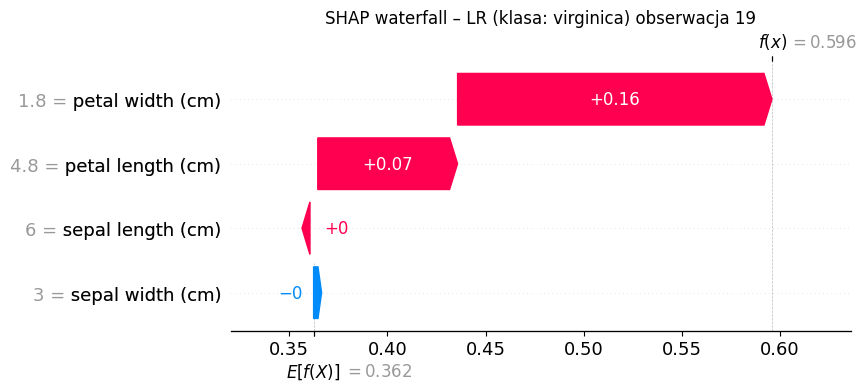

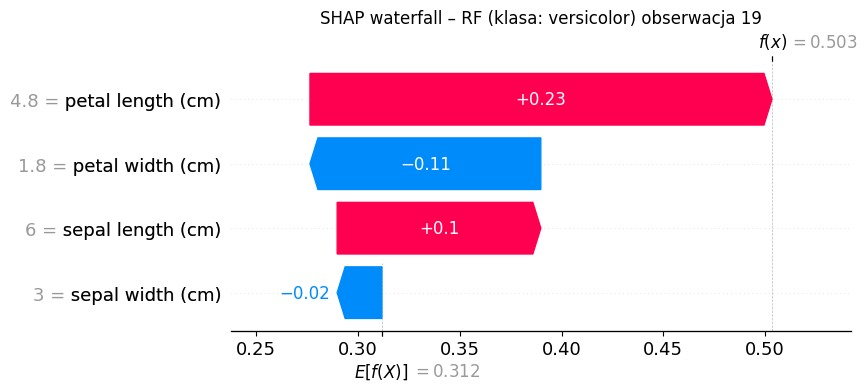

In [ ]:
exp_lr_idx2 = select_class_explanation(sv_lr_one_idx2, pred_class_lr_idx2)
exp_rf_idx2 = select_class_explanation(sv_rf_one_idx2, pred_class_rf_idx2)

plt.figure()
shap.plots.waterfall(exp_lr_idx2, show=False)
plt.title(f"SHAP waterfall – LR (klasa: {class_names[pred_class_lr_idx2]}) obserwacja {idx2}")
plt.show()

plt.figure()
shap.plots.waterfall(exp_rf_idx2, show=False)
plt.title(f"SHAP waterfall – RF (klasa: {class_names[pred_class_rf_idx2]}) obserwacja {idx2}")
plt.show()

Dla obserwacji 19 widoczna jest rozbieżność w lokalnych wyjaśnieniach, która prowadzi do odmiennej klasyfikacji przez oba modele. Regresja logistyczna przypisuje największy dodatni wkład cechom petal width i petal length, co przesuwa predykcję w stronę klasy virginica, natomiast w Random Forest wpływ petal width działa w przeciwnym kierunku, co skutkuje klasyfikacją jako versicolor. Przykład ten pokazuje, że różnice w sposobie agregowania informacji przez modele mogą prowadzić do błędnych predykcji mimo podobnych wartości cech wejściowych.

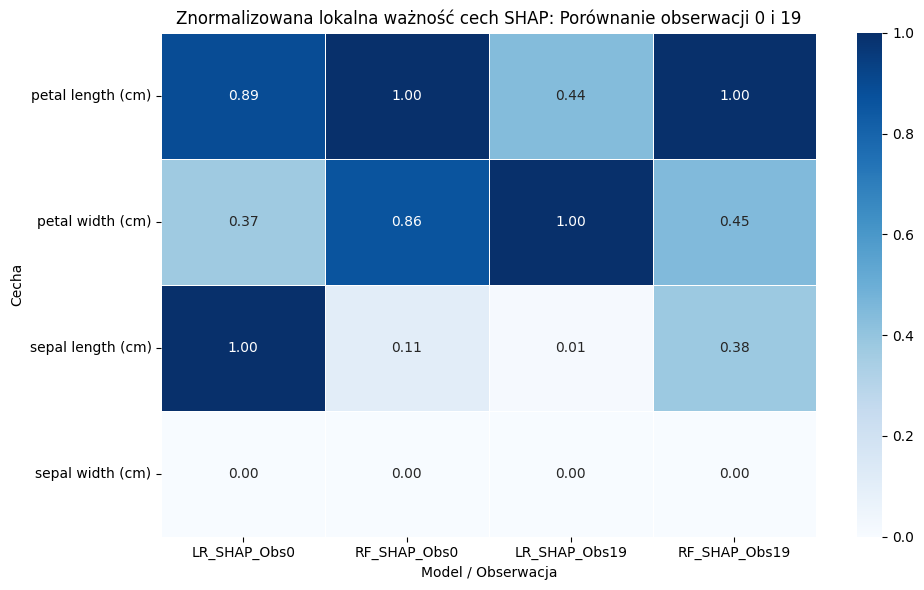

In [ ]:
import seaborn as sns

combined_local_shap_comparison_df = pd.DataFrame({
    "LR_SHAP_Obs0": lr_contrib,
    "RF_SHAP_Obs0": rf_contrib,
    "LR_SHAP_Obs19": lr_contrib_idx2,
    "RF_SHAP_Obs19": rf_contrib_idx2
}).fillna(0)

# Normalize absolute SHAP values for better comparison
normalized_local_shap_comparison_df = combined_local_shap_comparison_df.abs().apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_local_shap_comparison_df, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title("Znormalizowana lokalna ważność cech SHAP: Porównanie obserwacji 0 i 19")
plt.xlabel("Model / Obserwacja")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()

Porównanie lokalnych wartości SHAP dla obserwacji 0 i 19 pokazuje wyraźną różnicę w strukturze wpływu cech na predykcję modeli. Dla obserwacji 0, poprawnie sklasyfikowanej przez oba modele, zarówno regresja logistyczna, jak i Random Forest wskazują spójną dominację cech płatków, co prowadzi do stabilnej i jednoznacznej decyzji. W przypadku obserwacji 19 widoczna jest większa niejednoznaczność – regresja logistyczna nadal opiera decyzję głównie na cechach płatków, natomiast Random Forest silniej reaguje na konkurencyjne wpływy cech, co prowadzi do błędnej klasyfikacji. Wynik ten potwierdza, że przypadki leżące bliżej granic decyzyjnych są bardziej podatne na rozbieżności między modelami, co dobrze uwidacznia analiza lokalna SHAP.

###Lime

- generuje punkty wokół obserwacji
- patrzy jak model zachowuje się w okolicy
- dopasowuje prosty model

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer_lime = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

lime_lr = explainer_lime.explain_instance(
    data_row=x0_np[0],
    predict_fn=lr_clf.predict_proba,
    num_features=len(feature_names)
)

lime_rf = explainer_lime.explain_instance(
    data_row=x0_np[0],
    predict_fn=rf_clf.predict_proba,
    num_features=len(feature_names)
)

print("LIME (LR) – top wkłady dla klasy:", pred_lr)
display(pd.DataFrame(lime_lr.as_list(), columns=["feature_range", "weight"]))

print("LIME (RF) – top wkłady dla klasy:", pred_rf)
display(pd.DataFrame(lime_rf.as_list(), columns=["feature_range", "weight"]))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME (LR) – top wkłady dla klasy: setosa


,feature_range,weight
0,sepal length (cm) <= 5.10,-0.263198
1,petal length (cm) <= 1.60,-0.097778
2,petal width (cm) <= 0.30,0.067317
3,2.80 < sepal width (cm) <= 3.00,0.037606


LIME (RF) – top wkłady dla klasy: setosa


,feature_range,weight
0,petal length (cm) <= 1.60,-0.219253
1,petal width (cm) <= 0.30,-0.149965
2,sepal length (cm) <= 5.10,-0.074269
3,2.80 < sepal width (cm) <= 3.00,-0.003528


Wyjaśnienia LIME wskazują, że dla obu modeli największy wpływ na klasyfikację obserwacji jako setosa mają niskie wartości petal length i petal width, które silnie zwiększają prawdopodobieństwo tej klasy. Cechy kielicha pojawiają się z mniejszymi wagami, co potwierdza, że lokalnie decyzja modelu opiera się głównie na informacjach o płatkach, a wyniki LIME są spójne z wyjaśnieniami SHAP.

In [ ]:
explainer_lime_idx2 = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

lime_lr_idx2 = explainer_lime_idx2.explain_instance(
    data_row=x0_np2[0],
    predict_fn=lr_clf.predict_proba,
    num_features=len(feature_names)
)

lime_rf_idx2 = explainer_lime_idx2.explain_instance(
    data_row=x0_np2[0],
    predict_fn=rf_clf.predict_proba,
    num_features=len(feature_names)
)

print("LIME (LR) – top wkłady dla klasy (", idx2, "):", pred_lr2)
display(pd.DataFrame(lime_lr_idx2.as_list(), columns=["feature_range", "weight"]))

print("LIME (RF) – top wkłady dla klasy (", idx2, "):", pred_rf2)
display(pd.DataFrame(lime_rf_idx2.as_list(), columns=["feature_range", "weight"]))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


LIME (LR) – top wkłady dla klasy ( 19 ): virginica


,feature_range,weight
0,5.75 < sepal length (cm) <= 6.40,0.107218
1,4.25 < petal length (cm) <= 5.10,0.062271
2,2.80 < sepal width (cm) <= 3.00,0.043162
3,1.30 < petal width (cm) <= 1.80,-0.016531


LIME (RF) – top wkłady dla klasy ( 19 ): versicolor


,feature_range,weight
0,4.25 < petal length (cm) <= 5.10,0.210496
1,1.30 < petal width (cm) <= 1.80,0.158081
2,5.75 < sepal length (cm) <= 6.40,0.043530
3,2.80 < sepal width (cm) <= 3.00,-0.009092


In [ ]:
lime_lr_contrib_series_idx2 = extract_lime_features(lime_lr_idx2.as_list(), feature_names)
lime_rf_contrib_series_idx2 = extract_lime_features(lime_rf_idx2.as_list(), feature_names)

display(pd.DataFrame({
    "LIME_LR_local_idx2": lime_lr_contrib_series_idx2,
    "LIME_RF_local_idx2": lime_rf_contrib_series_idx2
}))

,LIME_LR_local_idx2,LIME_RF_local_idx2
sepal length (cm),0.107218,0.043530
sepal width (cm),0.043162,-0.009092
petal length (cm),0.062271,0.210496
petal width (cm),-0.016531,0.158081


###Wizualizacja LIME

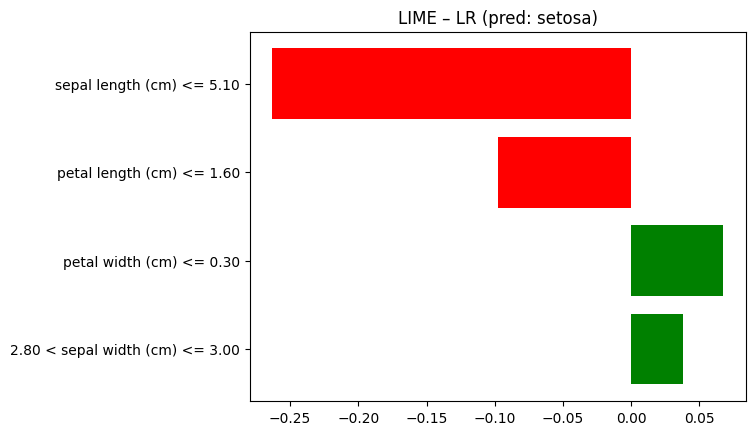

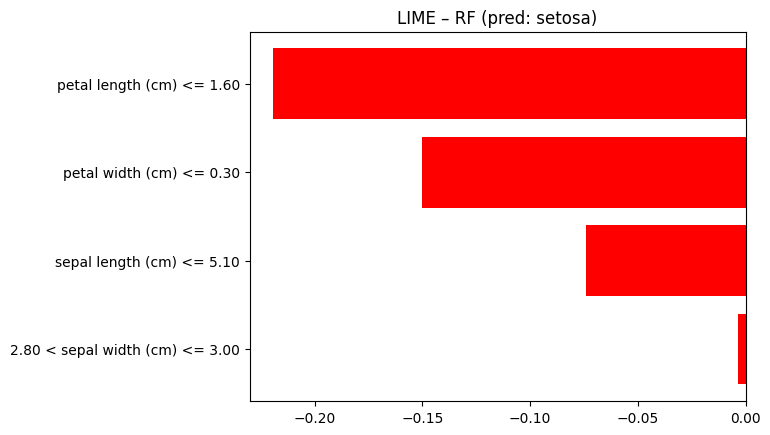

In [ ]:
Wfig = lime_lr.as_pyplot_figure()
plt.title(f"LIME – LR (pred: {pred_lr})")
plt.show()

fig = lime_rf.as_pyplot_figure()
plt.title(f"LIME – RF (pred: {pred_rf})")
plt.show()

Różnice w długości słupków pomiędzy regresją logistyczną a Random Forest wynikają z odmiennego sposobu podejmowania decyzji przez modele, jednak oba wskazują na te same kluczowe cechy lokalne.

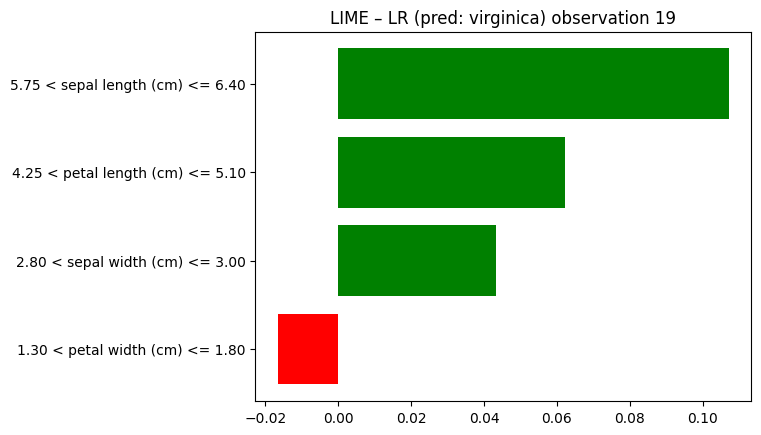

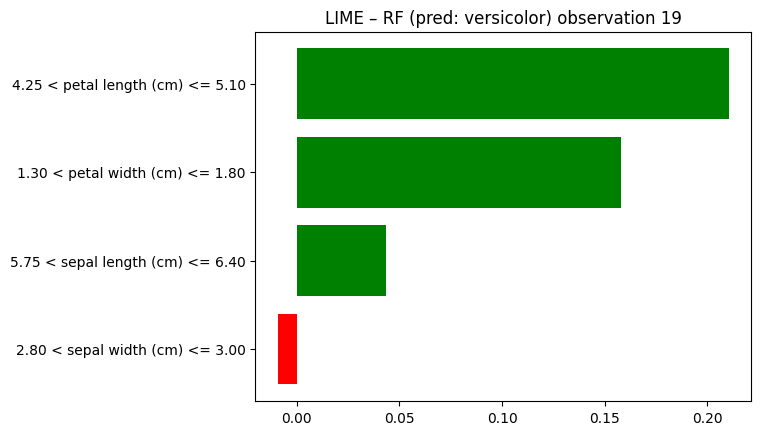

In [ ]:
fig_lr_idx2 = lime_lr_idx2.as_pyplot_figure()
plt.title(f"LIME – LR (pred: {pred_lr2}) observation {idx2}")
plt.show()

fig_rf_idx2 = lime_rf_idx2.as_pyplot_figure()
plt.title(f"LIME – RF (pred: {pred_rf2}) observation {idx2}")
plt.show()

Wizualizacje LIME dla obserwacji 19 wskazują bardzo podobny zestaw istotnych cech w obu modelach, głównie petal length i petal width, mimo że Random Forest dokonał błędnej klasyfikacji. Oznacza to, że lokalne przybliżenie liniowe używane przez LIME uchwyciło podobną strukturę wpływu cech, lecz nie odzwierciedliło w pełni nieliniowych zależności i interakcji obecnych w Random Forest. W efekcie wyjaśnienie LIME może wyglądać spójnie, mimo że rzeczywista decyzja modelu opiera się na bardziej złożonym mechanizmie prowadzącym do pomyłki.

##Porównanie metod

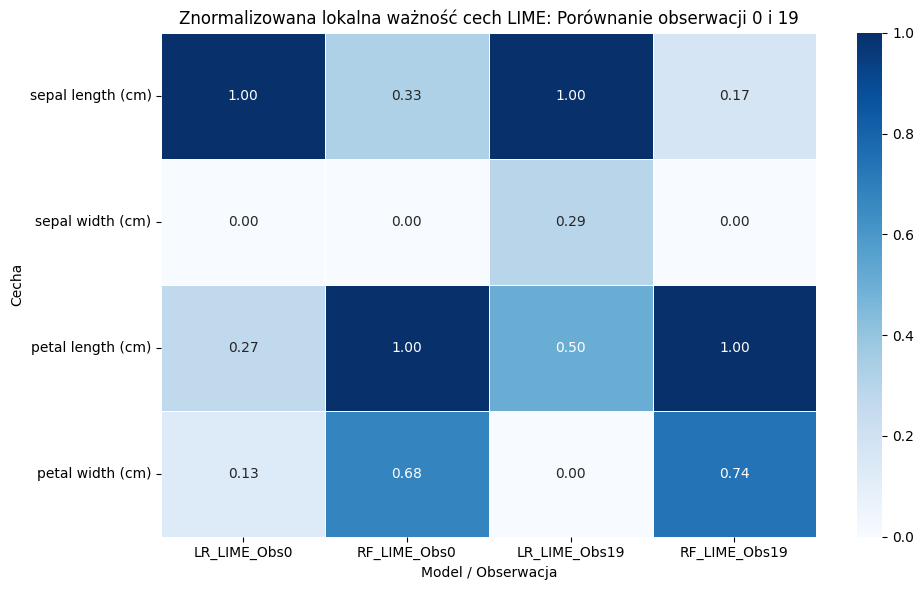

In [ ]:
def extract_lime_features(lime_exp_list, feature_names):
    feature_weights = {}
    for exp_str, weight in lime_exp_list:
        found = False
        for fn in feature_names:
            if fn in exp_str:
                feature_weights[fn] = feature_weights.get(fn, 0) + weight
                found = True
                break
    return pd.Series(feature_weights).reindex(feature_names).fillna(0)

lime_lr_contrib_series_obs0 = extract_lime_features(lime_lr.as_list(), feature_names)
lime_rf_contrib_series_obs0 = extract_lime_features(lime_rf.as_list(), feature_names)

lime_lr_contrib_series_obs19 = extract_lime_features(lime_lr_idx2.as_list(), feature_names)
lime_rf_contrib_series_obs19 = extract_lime_features(lime_rf_idx2.as_list(), feature_names)

combined_local_lime_comparison_df = pd.DataFrame({
    "LR_LIME_Obs0": lime_lr_contrib_series_obs0,
    "RF_LIME_Obs0": lime_rf_contrib_series_obs0,
    "LR_LIME_Obs19": lime_lr_contrib_series_obs19,
    "RF_LIME_Obs19": lime_rf_contrib_series_obs19
}).fillna(0)
normalized_local_lime_comparison_df = combined_local_lime_comparison_df.abs().apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_local_lime_comparison_df, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title("Znormalizowana lokalna ważność cech LIME: Porównanie obserwacji 0 i 19")
plt.xlabel("Model / Obserwacja")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()

Znormalizowana mapa cieplna lokalnej ważności cech uzyskanej metodą LIME pokazuje, w jaki sposób modele interpretują dwie różne obserwacje: 0 (poprawnie sklasyfikowaną przez oba modele) oraz 19 (błędnie sklasyfikowaną przez Random Forest). Dla obserwacji 0 widoczna jest relatywnie spójna struktura wyjaśnień, w której dominują cechy płatków, a różnice między modelami wynikają głównie z odmiennej wagi przypisywanej poszczególnym cechom. W przypadku obserwacji 19 rozkład ważności cech staje się mniej jednoznaczny — istotne są te same cechy co wcześniej, jednak ich względna rola ulega zmianie, szczególnie w modelu Random Forest. Taka niestabilność wyjaśnień lokalnych może wynikać z faktu, że obserwacja leży blisko granicy decyzyjnej, a LIME, jako metoda oparta na lokalnym przybliżeniu liniowym, jest wrażliwa na sposób próbkowania otoczenia i korelacje cech. W efekcie wyjaśnienia mogą wyglądać podobnie, mimo że rzeczywista decyzja modelu opiera się na bardziej złożonych, nieliniowych zależnościach, co prowadzi do błędnej klasyfikacji.

## Wizualizacja spójności ważności cech: Mapa cieplna znormalizowanych wyników

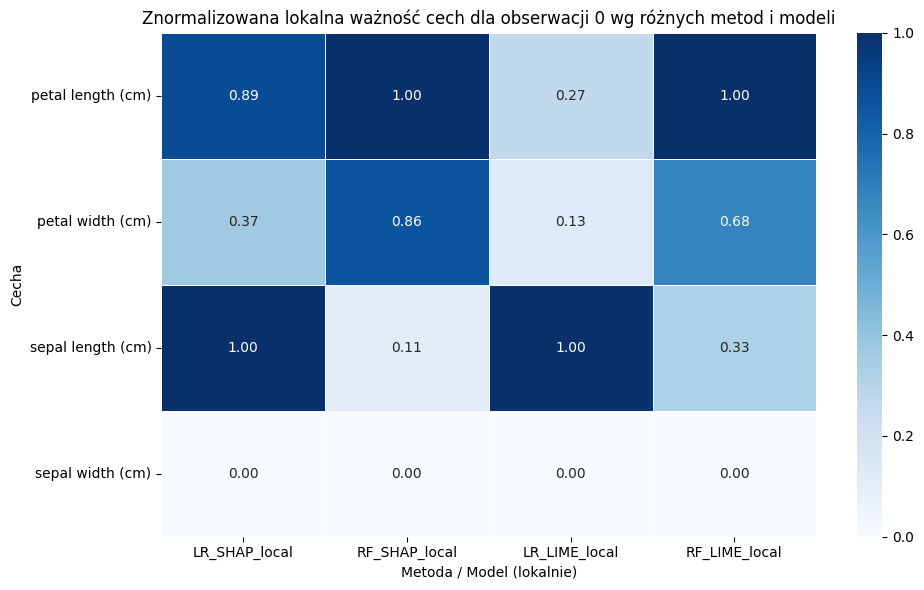

In [ ]:
import seaborn as sns

def extract_lime_features(lime_exp_list, feature_names):
    feature_weights = {}
    for exp_str, weight in lime_exp_list:
        found = False
        for fn in feature_names:
            if fn in exp_str:
                feature_weights[fn] = feature_weights.get(fn, 0) + weight
                found = True
                break
    return pd.Series(feature_weights).reindex(feature_names).fillna(0)

lime_lr_contrib_series = extract_lime_features(lime_lr.as_list(), feature_names)
lime_rf_contrib_series = extract_lime_features(lime_rf.as_list(), feature_names)

combined_local_importance_df = pd.DataFrame({
    "LR_SHAP_local": lr_contrib,
    "RF_SHAP_local": rf_contrib,
    "LR_LIME_local": lime_lr_contrib_series,
    "RF_LIME_local": lime_rf_contrib_series
}).fillna(0)

normalized_local_importance_df = combined_local_importance_df.abs().apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_local_importance_df, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title(f"Znormalizowana lokalna ważność cech dla obserwacji {idx} wg różnych metod i modeli")
plt.xlabel("Metoda / Model (lokalnie)")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()

Znormalizowana mapa cieplna lokalnej ważności cech pozwala porównać, jak różne metody wyjaśniania i modele interpretują tę samą pojedynczą obserwację. W większości przypadków widoczna jest spójność – zarówno SHAP, jak i LIME dla obu modeli wskazują cechy płatków jako istotne, przy czym petal length oraz petal width najczęściej mają najwyższe znaczenie, a sepal width pozostaje nieistotna. Wyraźnym wyjątkiem jest wyjaśnienie LR_LIME_local, w którym dominującą rolę przejmuje sepal length, co odróżnia ten wynik od pozostałych metod. Tę rozbieżność można wyjaśnić charakterem LIME, który buduje lokalny, uproszczony model liniowy na losowo próbkowanych danych w otoczeniu obserwacji, przez co bywa bardziej wrażliwy na zakres próbkowania i korelacje cech. W przeciwieństwie do tego SHAP dostarcza stabilniejszych i bardziej spójnych wyjaśnień, co w tym porównaniu potwierdza jego większą odporność na lokalne fluktuacje i czyni go bardziej wiarygodnym narzędziem do analizy pojedynczych predykcji.

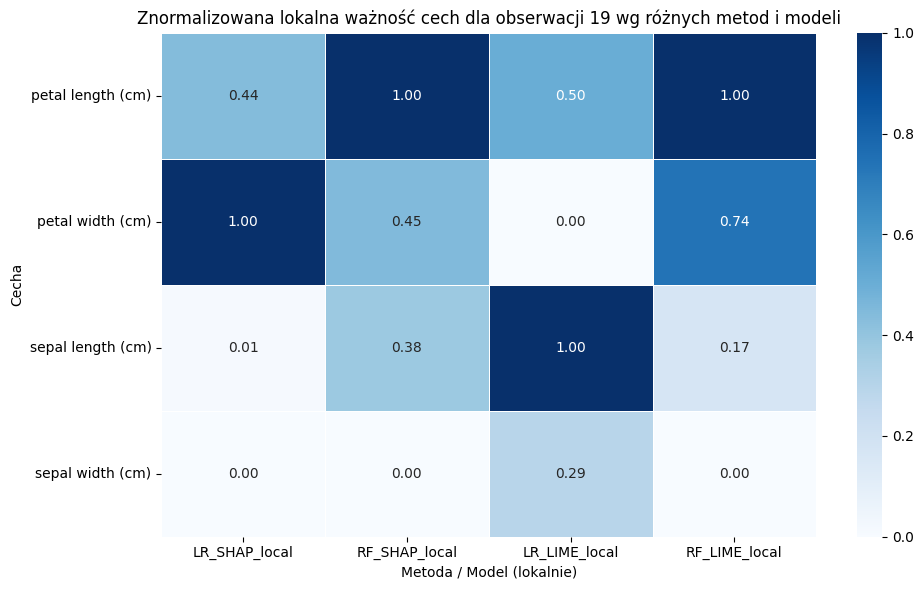

In [ ]:
combined_local_importance_df_idx2 = pd.DataFrame({
    "LR_SHAP_local": lr_contrib_idx2,
    "RF_SHAP_local": rf_contrib_idx2,
    "LR_LIME_local": lime_lr_contrib_series_idx2,
    "RF_LIME_local": lime_rf_contrib_series_idx2
}).fillna(0)

normalized_local_importance_df_idx2 = combined_local_importance_df_idx2.abs().apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_local_importance_df_idx2, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title(f"Znormalizowana lokalna ważność cech dla obserwacji {idx2} wg różnych metod i modeli")
plt.xlabel("Metoda / Model (lokalnie)")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()

Znormalizowana mapa cieplna lokalnej ważności cech dla obserwacji 19 pokazuje wyraźne różnice w sposobie wyjaśniania tej samej predykcji przez różne metody i modele. Metody SHAP dla obu modeli wskazują dominującą rolę cech płatków, jednak ich względna ważność różni się między regresją logistyczną a Random Forest, co odzwierciedla odmienne mechanizmy decyzyjne modeli. W przypadku LIME widoczna jest większa niestabilność wyjaśnień, szczególnie dla regresji logistycznej, gdzie istotną rolę przejmuje sepal length, co nie występuje w SHAP ani w RF. Porównanie to pokazuje, że dla trudnych, granicznych obserwacji interpretacje lokalne silnie zależą od zastosowanej metody wyjaśniania, a SHAP dostarcza bardziej spójnych i stabilnych wyników niż LIME.